# plotting eQTLs

### Kynon Jade Benjamin and Apuã Paquola

In [1]:
import re
import functools
import subprocess
import numpy as np
import pandas as pd
from plotnine import *
from pandas_plink import read_plink
from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [2]:
config = {
    #'de_file': '/ceph/projects/v2_phase3_paper/inputs/differentialExpression/_m/genes/diffExpr_szVctl_full.txt',
    'biomart_file': '../_h/biomart.csv',
    'residual_expression_file': '../../_m/genes_residualized_expression.csv',
    'phenotype_file': '/ceph/projects/v3_phase3_paper/inputs/phenotypes/merged/_m/merged_phenotypes.csv',
    'plink_file_prefix': '/ceph/projects/v3_phase3_paper/inputs/genotypes/to_brnum/phase3_plink/_m/phase3',
    'matrixeqtl_output_file': '../../../_m/cis_eqtls_genes.ctxt',
    'gwas_snp_file': '/ceph/projects/v3_phase3_paper/inputs/gwas/PGC2_CLOZUK/map_phase3/_m/libd_hg38_pggc2sz_snps.tsv'
}

In [3]:
@functools.lru_cache()
def get_biomart_df():
    biomart = pd.read_csv(config['biomart_file'])
    biomart['description'] = biomart['description'].str.replace('\[Source.*$','')
    return biomart


@functools.lru_cache()
def get_residual_expression_df():
    residual_expression_df = pd.read_csv(config['residual_expression_file'], index_col=0).transpose()
    return residual_expression_df


@functools.lru_cache()
def get_pheno_df():
    pheno_df = pd.read_csv(config['phenotype_file'], index_col=0)
    return pheno_df


@functools.lru_cache()
def get_expression_and_pheno_df():
    return pd.merge(get_pheno_df(), get_residual_expression_df(), left_index=True, right_index=True)


@functools.lru_cache()
def get_de_df(filename):
    de_df = pd.read_csv(filename, sep='\t', index_col=0, usecols=[0]+list(range(5,13)))
    return de_df


def get_gene_symbol(gene_id, biomart=get_biomart_df()):
    ensge = re.sub('\..+$','', gene_id)
    ggg = biomart[biomart['ensembl_gene_id']==ensge]
    if ggg.shape[0]==0:
        return '', ''
    gs = ggg['external_gene_name'].values[0]
    de = ggg['description'].values[0]
    if type(de)!=str:
        de = ''
    de = re.sub('\[Source:.*$','',de)
    return gs, de



@functools.lru_cache()
def get_gene_id_df():
    return pd.DataFrame({'gene_id': get_residual_expression_df().columns,
                         'ensembl_gene_id': get_residual_expression_df().columns.str.replace('\..+$','')})


@functools.lru_cache()
def gene_info_from_symbol(gene_symbol):
    gene_id_df = get_gene_id_df()
    biomart=get_biomart_df()
    r = biomart[biomart['external_gene_name']==gene_symbol].merge(gene_id_df, on='ensembl_gene_id', how='left')
    return r


@functools.lru_cache()
def gene_id_from_symbol(gene_symbol):
    df = gene_info_from_symbol(gene_symbol)
    assert df.shape[0] == 1
    return df[['gene_id']].iloc[0].values[0]


@functools.lru_cache()
def get_plink_tuple():
    '''
    Usage: (bim, fam, bed) = get_plink_tuple()
    '''
    return read_plink(config['plink_file_prefix'])


@functools.lru_cache()
def get_eqtl_df(fdr=0.05):
    with subprocess.Popen('''awk ' ($6<%f) || (NR==1) {print}' %s ''' % 
                          (fdr, config['matrixeqtl_output_file']),
                          shell=True, stdout=subprocess.PIPE) as p:
        eqtl_df = pd.read_csv(p.stdout, sep='\t')
    return eqtl_df


@functools.lru_cache()
def get_gwas_snps():
    return pd.read_csv(config['gwas_snp_file'], sep='\t', index_col=0)
 
    
def get_gwas_snp(snp_id):
    gwas = get_gwas_snps()
    r = gwas[gwas['our_snp_id']==snp_id]
    assert len(r) == 1
    return r


In [4]:
def letter_snp(number, a0, a1):
    '''
    Example:
    letter_snp(0, 'A', 'G') is 'AA'
    letter_snp(1, 'A', 'G') is 'AG'
    letter_snp(2, 'A', 'G') is 'GG'
    
    '''
    if np.isnan(number):
        return np.nan
    if len(a0)==1 and len(a1)==1:
        sep = ''
    else:
        sep = ' '
    return sep.join(sorted([a0]*int(number) + [a1]*(2-int(number))))


In [5]:
@functools.lru_cache()
def get_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the same as in the plink files.
    
    Example: 
    get_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
    Br5168             0              GG    0\nGG
    Br2582             1              AG    1\nAG
    Br2378             1              AG    1\nAG
    Br5155             2              AA    2\nAA
    Br5182             2              AA    2\nAA
    '''
    (bim, fam, bed) = get_plink_tuple()
    brain_ids = list(set(get_expression_and_pheno_df()['BrNum']).intersection(set(fam['fid'])))
    snp_info = bim[bim['snp']==snp_id]
    snp_pos = snp_info.iloc[0]['i']
    fam_pos = list(fam.set_index('fid').loc[brain_ids]['i'])
    dfsnp = (pd.DataFrame(bed[[snp_pos]].compute()[:,fam_pos], 
                          columns=brain_ids, index=[snp_id + '_num'])
             .transpose().dropna())
    my_letter_snp = functools.partial(letter_snp, a0=snp_info.iloc[0]['a0'], a1=snp_info.iloc[0]['a1'])
    # the 2 - in next line is to workarount a possible bug in pandas_plink? a1 and a0 inverted
    dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']].astype('int')
    dfsnp[snp_id + '_letter'] = dfsnp[snp_id + '_num'].apply(my_letter_snp)
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    return dfsnp

In [6]:
@functools.lru_cache()
def get_gwas_ordered_snp_df(snp_id):
    '''
    Returns a dataframe containing the genotype on snp snp_id.
    The allele count is the number of risk alleles according to GWAS.
    
    Example: 
    get_gwas_ordered_snp_df('rs653953').head(5)
    
            rs653953_num rs653953_letter rs653953
    Br5168             2              GG    2\nGG
    Br2582             1              AG    1\nAG
    Br2378             1              AG    1\nAG
    Br5155             0              AA    0\nAA
    Br5182             0              AA    0\nAA
    '''
    pgc = get_gwas_snps()
    dfsnp = get_snp_df(snp_id).copy()
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['pgc2_a1_same_as_our_counted'].iloc[0]:
        if gwas_snp['OR'].iloc[0] > 1:
            pass
        else:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
    else:
        if gwas_snp['OR'].iloc[0] > 1:
            dfsnp[[snp_id + '_num']] = 2 - dfsnp[[snp_id + '_num']]
        else:
            pass
    dfsnp[snp_id] = (dfsnp[snp_id + '_num'].astype('str') + '\n' + 
                     dfsnp[snp_id + '_letter'].astype('str')).astype('category')
    
    return dfsnp

In [7]:
@functools.lru_cache()
def get_risk_allele(snp_id):
    gwas_snp = get_gwas_snp(snp_id)
    if gwas_snp['OR'].iloc[0] > 1:
        ra = gwas_snp['A1'].iloc[0]
    else:
        ra = gwas_snp['A2'].iloc[0]
    return ra

In [15]:
def get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func):
    pheno_columns = list(get_pheno_df().columns)
    expr_df = get_expression_and_pheno_df()[pheno_columns + [gene_id]]
    snp_df =  snp_df_func(snp_id)
    return expr_df.merge(snp_df, left_on='BrNum', right_index=True)
    

def simple_snp_expression_plot_impl(snp_id, gene_id, snp_df_func):
    df = get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func)
    y0 = df[gene_id].quantile(.01) - 0.26
    y1 = df[gene_id].quantile(.99) + 0.26
    p = ggplot(df, aes(x=snp_id, y=gene_id)) \
    + geom_boxplot(fill='red', alpha=0.4, outlier_alpha=0) \
    + geom_jitter(width=0.25, stroke=0, alpha=0.6) + ylim(y0, y1) \
    + theme_matplotlib()\
    + theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22))
    return p
    

def simple_snp_expression_plot(snp_id, gene_id):
    return simple_snp_expression_plot_impl(snp_id, gene_id, get_snp_df)


def simple_gwas_ordered_snp_expression_plot(snp_id, gene_id):
    return simple_snp_expression_plot_impl(snp_id, gene_id, get_gwas_ordered_snp_df)


def simple_snp_expression_pheno_plot_impl(snp_id, gene_id, snp_df_func, pheno_var):
    df = get_snp_gene_pheno_df(snp_id, gene_id, snp_df_func)
    y0 = df[gene_id].quantile(.01) - 0.26
    y1 = df[gene_id].quantile(.99) + 0.26
    pjd = position_jitterdodge(jitter_width=0.22)
    p = ggplot(df, aes(x=snp_id, y=gene_id, fill=pheno_var)) \
    + geom_boxplot(alpha=0.4, outlier_alpha=0) \
    + geom_jitter(position=pjd, stroke=0, alpha=0.6) + ylim(y0, y1) \
    + theme_matplotlib()\
    + theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22), 
            legend_text=element_text(size=14))
    return p


In [20]:
def gwas_annotation(snp_id):
    return 'SZ GWAS pvalue: %.1e' % get_gwas_snp(snp_id).iloc[0]['P']


def eqtl_interaction_annotation(snp_id, gene_id):
    eqtl_df = get_eqtl_df()
    r = eqtl_df[(eqtl_df['SNP']==snp_id) & (eqtl_df['gene']==gene_id)]
    assert len(r)==1
    return 'genotype:brain region eQTL FDR: %.1e' % r.iloc[0]['FDR']


def risk_allele_annotation(snp_id):
    return 'SZ risk allele: %s' % get_risk_allele(snp_id)


def annotated_genotype_brain_region_interaction_eqtl_plot(snp_id, gene_id):
    p = simple_snp_expression_pheno_plot_impl(snp_id, gene_id,
                                              get_snp_df, 'Region')
    gene_symbol, gene_description = get_gene_symbol(gene_id)
    title ="\n".join([gene_symbol,
                      eqtl_interaction_annotation(snp_id, gene_id)])
    p += ggtitle(title) + ylab('Residualized expression')
    return p


def gwas_annotated_genotype_brain_region_interaction_eqtl_plot(snp_id, gene_id):
    p = simple_snp_expression_pheno_plot_impl(snp_id, gene_id, 
                                              get_gwas_ordered_snp_df, 'Region')
    gene_symbol, gene_description = get_gene_symbol(gene_id)
    title ="\n".join([gene_symbol,
                      risk_allele_annotation(snp_id),
                      gwas_annotation(snp_id),     
                      eqtl_interaction_annotation(snp_id, gene_id)])
    p += ggtitle(title) + ylab('Residualized expression')
    return p


def save_plot(p, fn):
    for ext in ['png', 'pdf', 'svg']:
        p.save(fn + '.' + ext)
    

# Top 10 eQTLs

In [10]:
eqtl_df = get_eqtl_df()
eqtl_df.head()

,SNP,gene,beta,t-stat,p-value,FDR
0,rs949315:22123743:A:G,ENSG00000266489.1,1.056601,39.812156,1.937021e-186,5.997866e-179
1,rs1791270:22123778:C:T,ENSG00000266489.1,1.056601,39.812156,1.937021e-186,5.997866e-179
2,rs1945168,ENSG00000266489.1,1.043788,38.182411,2.249171e-177,4.642945e-170
3,rs955621:22122783:T:G,ENSG00000266489.1,1.047159,37.427851,3.912645e-173,6.057632e-166
4,rs72832062:81877470:T:C,ENSG00000197943.9,-0.603238,-34.222870,7.695880e-155,9.531926e-148


top_0_interaction_eqtl_caudate_dlpfc 0 rs949315:22123743:A:G ENSG00000266489.1


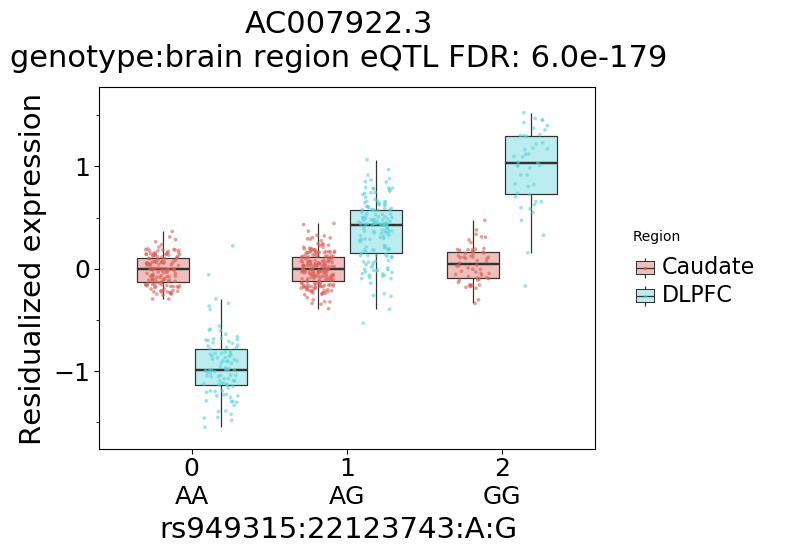

<ggplot: (8786303948192)>
top_1_interaction_eqtl_caudate_dlpfc 1 rs72832062:81877470:T:C ENSG00000197943.9


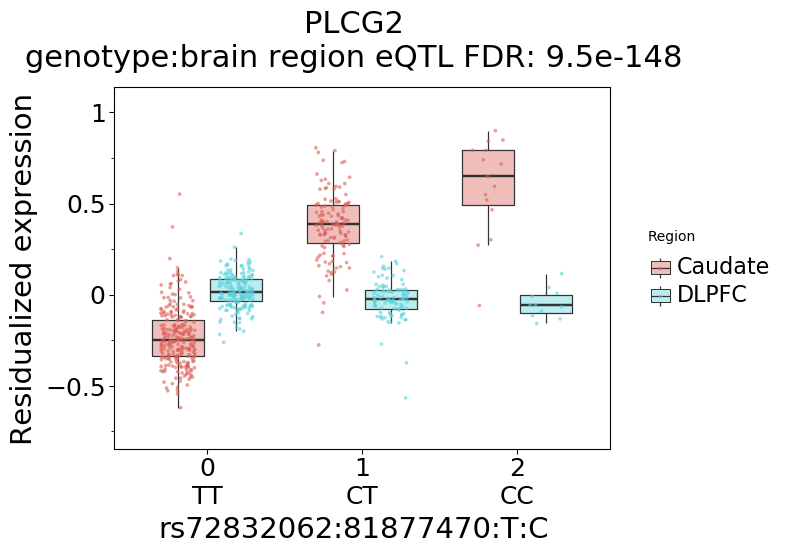

<ggplot: (8786303783729)>
top_2_interaction_eqtl_caudate_dlpfc 2 rs2279728 ENSG00000232394.1


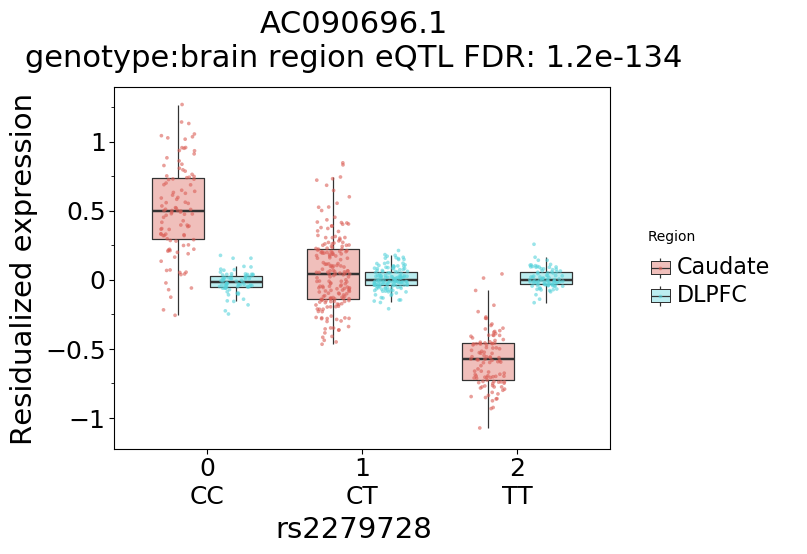

<ggplot: (8786304549699)>
top_3_interaction_eqtl_caudate_dlpfc 3 rs8023462:78914734:C:T ENSG00000080644.15


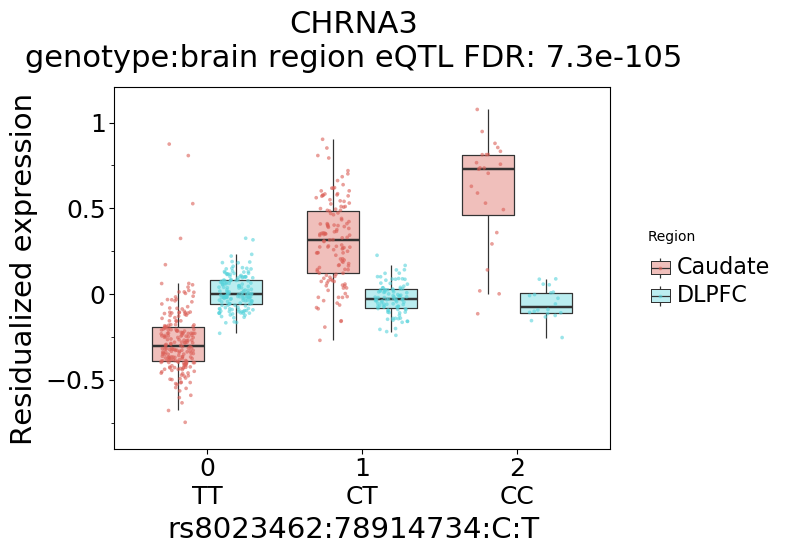

<ggplot: (8786291684160)>
top_4_interaction_eqtl_caudate_dlpfc 4 rs4245132 ENSG00000255545.7


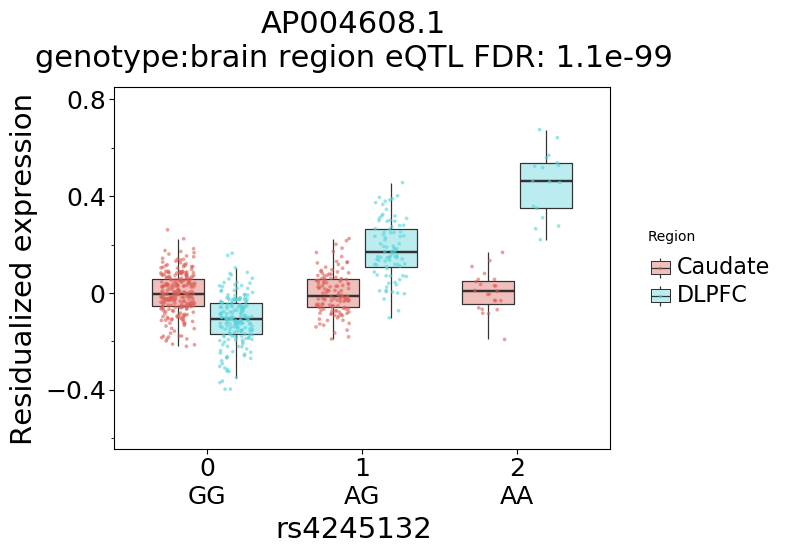

<ggplot: (8786303781373)>
top_5_interaction_eqtl_caudate_dlpfc 5 rs9963191 ENSG00000261738.6


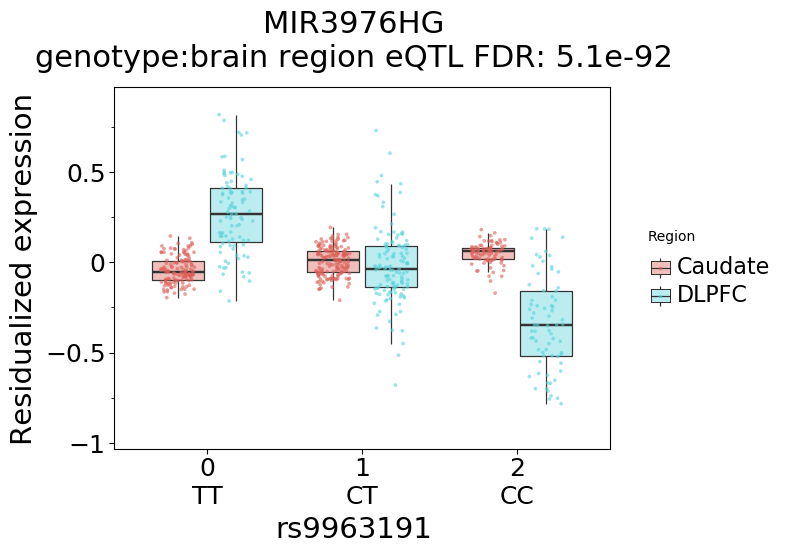

<ggplot: (8786304204282)>
top_6_interaction_eqtl_caudate_dlpfc 6 rs35164802:132044301:G:C ENSG00000014257.15


/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


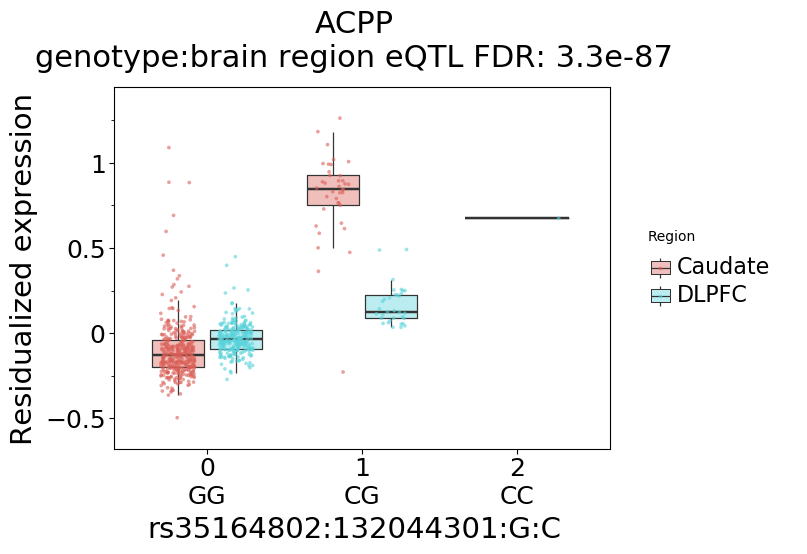

<ggplot: (8786304119173)>


/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/home/jbenja13/.local/lib/python3.8/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To a

top_7_interaction_eqtl_caudate_dlpfc 7 rs2314617:155017188:A:G ENSG00000240045.1


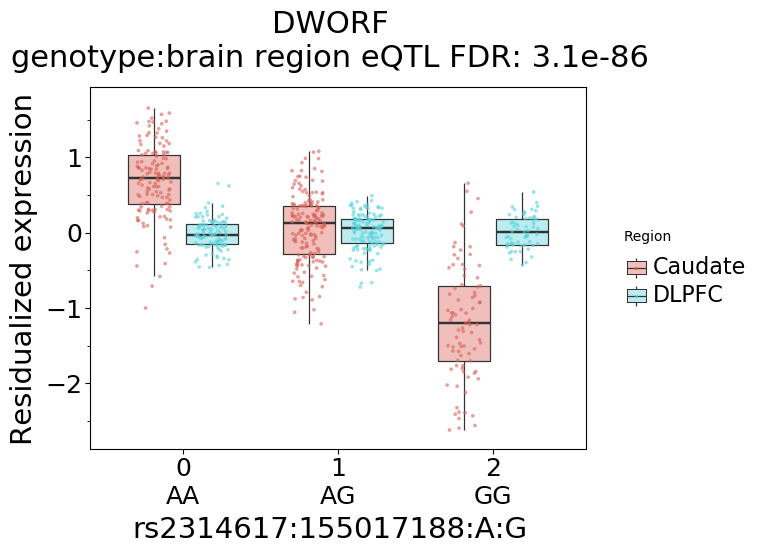

<ggplot: (8786304145246)>
top_8_interaction_eqtl_caudate_dlpfc 8 rs6711313:183416697:A:G ENSG00000115252.18


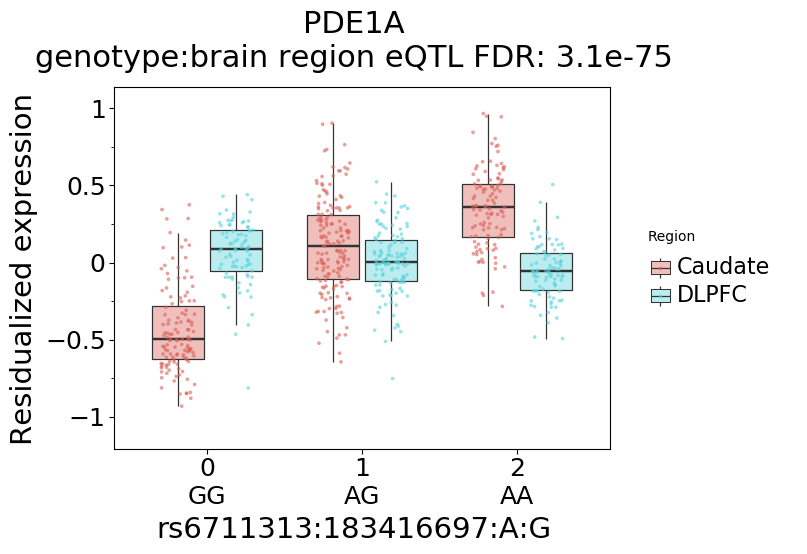

<ggplot: (8786337198225)>
top_9_interaction_eqtl_caudate_dlpfc 9 rs13387464:38895091:A:G ENSG00000143891.16


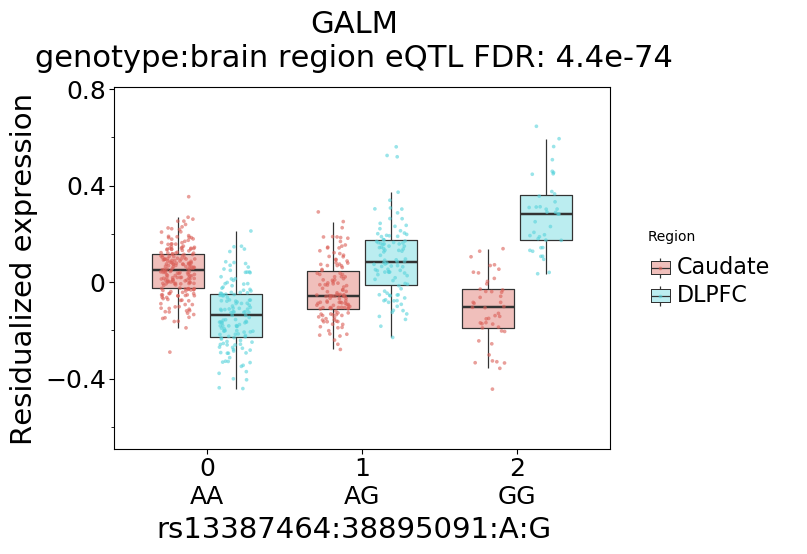

<ggplot: (8786304119140)>


In [14]:
top_10 = eqtl_df.sort_values('p-value', ascending=True).groupby('gene').first().sort_values('p-value').head(10).reset_index()
for x in top_10.itertuples():
    filename = "top_%d_interaction_eqtl_caudate_dlpfc" % x.Index
    p = annotated_genotype_brain_region_interaction_eqtl_plot(x.SNP, x.gene)
    print(filename, x.Index, x.SNP, x.gene)
    print(p)
    save_plot(p, filename)
    

# Top 10 eQTLs with GWAS significant index SNP

In [16]:
gwas_eqtl_df = eqtl_df.merge(get_gwas_snps(), left_on = 'SNP', right_on = 'our_snp_id', suffixes=['','_gwas'])
print(gwas_eqtl_df.shape)
gwas_eqtl_df.head()

/home/jbenja13/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/usr/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(280992, 28)


,SNP,gene,beta,t-stat,p-value,FDR,chrN,our_snp_id,cm,pos,...,A2,OR,SE,P,hg19chrc,hg38chrc,hg38pos,pgc2_a1_same_as_our_counted,rsid,is_index_snp
0,rs949315:22123743:A:G,ENSG00000266489.1,1.056601,39.812156,1.937021e-186,5.997866e-179,18,rs949315:22123743:A:G,0,22123743,...,G,0.99792,0.009725,0.8304,chr18,chr18,24543779,False,rs949315,False
1,rs1791270:22123778:C:T,ENSG00000266489.1,1.056601,39.812156,1.937021e-186,5.997866e-179,18,rs1791270:22123778:C:T,0,22123778,...,T,0.99805,0.009725,0.8409,chr18,chr18,24543814,False,rs1791270,False
2,rs1945168,ENSG00000266489.1,1.043788,38.182411,2.249171e-177,4.642945e-170,18,rs1945168,0,22124418,...,C,0.99701,0.009725,0.7578,chr18,chr18,24544454,False,rs1945168,False
3,rs955621:22122783:T:G,ENSG00000266489.1,1.047159,37.427851,3.912645e-173,6.057632e-166,18,rs955621:22122783:T:G,0,22122783,...,G,0.99805,0.009725,0.8407,chr18,chr18,24542819,False,rs955621,False
4,rs72832062:81877470:T:C,ENSG00000197943.9,-0.603238,-34.222870,7.695880e-155,9.531926e-148,16,rs72832062:81877470:T:C,0,81877470,...,C,0.98583,0.010248,0.1637,chr16,chr16,81843865,False,rs72832062,False


In [17]:
top_gwas_eqtl_df = gwas_eqtl_df[(gwas_eqtl_df['P']<5e-8) & (gwas_eqtl_df['is_index_snp'])].sort_values(['FDR', 'P'])
print(top_gwas_eqtl_df.shape)
top_gwas_eqtl_df.head()

(11, 28)


,SNP,gene,beta,t-stat,p-value,FDR,chrN,our_snp_id,cm,pos,...,A2,OR,SE,P,hg19chrc,hg38chrc,hg38pos,pgc2_a1_same_as_our_counted,rsid,is_index_snp
23998,rs10083370:104314182:G:A,ENSG00000088808.16,-0.063715,-7.581093,1.023439e-13,3.168064e-10,14,rs10083370:104314182:G:A,0,104314182,...,A,1.07800,0.009910,3.440000e-14,chr14,chr14,103847845,True,rs10083370,True
35458,rs12908161:85207825:A:G,ENSG00000259683.1,0.224242,6.709169,3.881143e-11,7.523535e-08,15,rs12908161:85207825:A:G,0,85207825,...,G,1.06890,0.010896,9.410000e-10,chr15,chr15,84664594,False,rs12908161,True
72076,rs3743078:78894759:C:G,ENSG00000080644.15,0.163804,5.714772,1.590249e-08,1.547342e-05,15,rs3743078:78894759:C:G,0,78894759,...,G,0.92481,0.011210,3.110000e-12,chr15,chr15,78602417,True,rs3743078,True
102591,rs111294930:152177121:A:G,ENSG00000249484.8,0.105464,5.167410,3.052960e-07,1.964302e-04,5,rs111294930:152177121:A:G,0,152177121,...,G,1.08580,0.012069,9.040000e-12,chr5,chr5,152797561,False,rs111294930,True
35459,rs12908161:85207825:A:G,ENSG00000259511.2,-0.120308,-4.530907,6.841543e-06,2.732221e-03,15,rs12908161:85207825:A:G,0,85207825,...,G,1.06890,0.010896,9.410000e-10,chr15,chr15,84664594,False,rs12908161,True


top_0_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 0 rs10083370:104314182:G:A ENSG00000088808.16


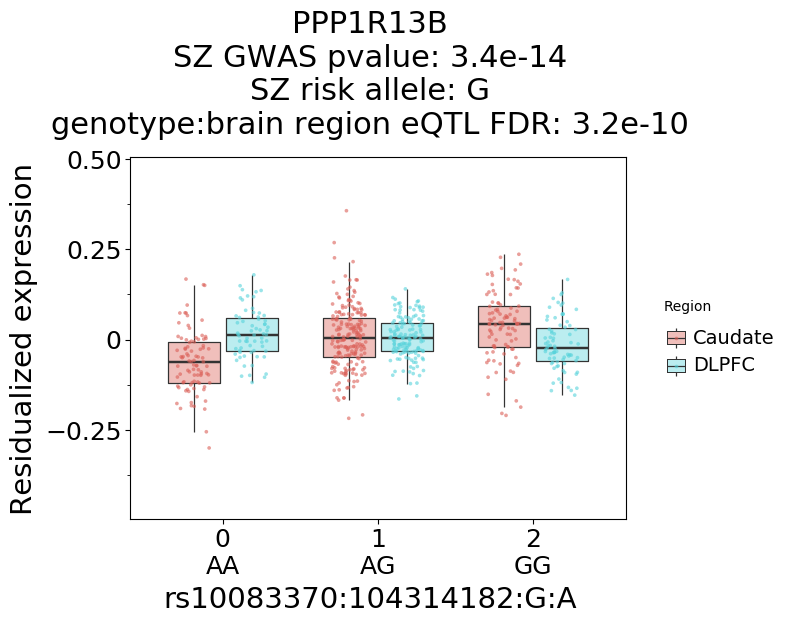

<ggplot: (8786303791674)>
top_1_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 1 rs12908161:85207825:A:G ENSG00000259683.1


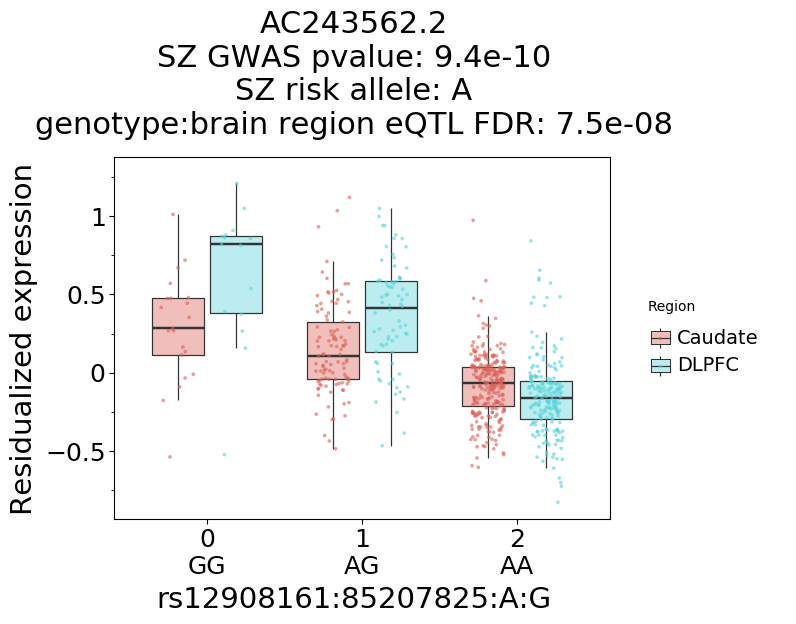

<ggplot: (8786303835715)>
top_2_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 2 rs3743078:78894759:C:G ENSG00000080644.15


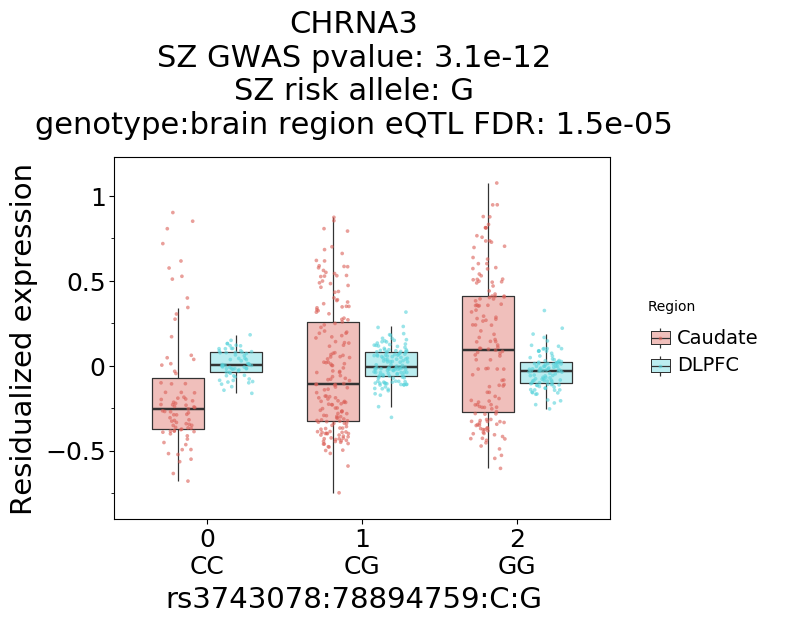

<ggplot: (8786304133702)>
top_3_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 3 rs111294930:152177121:A:G ENSG00000249484.8


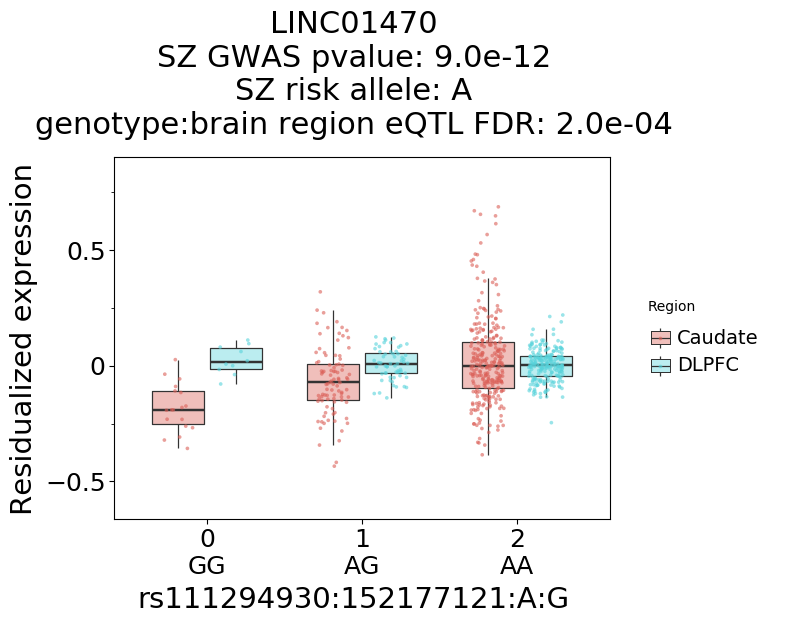

<ggplot: (8786304057474)>
top_4_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 4 rs12908161:85207825:A:G ENSG00000259511.2


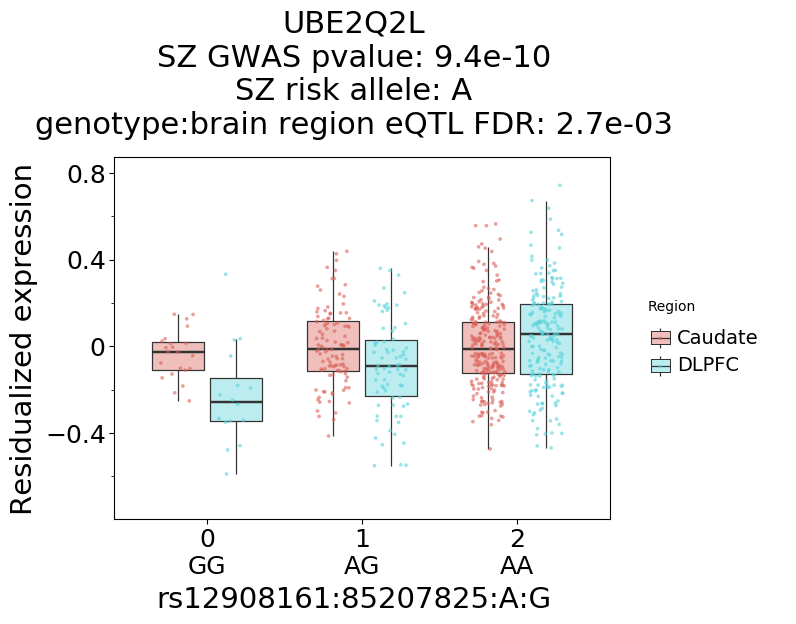

<ggplot: (8786304198943)>
top_5_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 5 rs4766428 ENSG00000196510.12


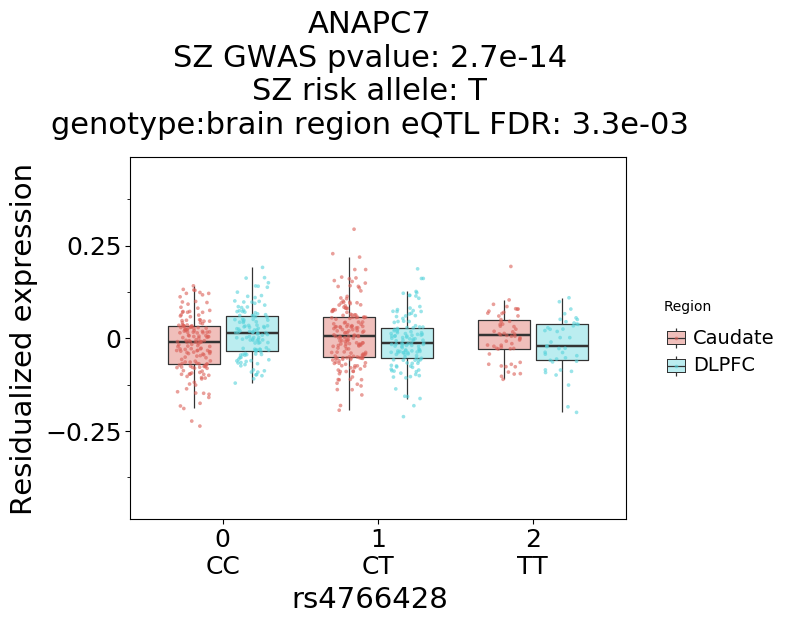

<ggplot: (8786303546085)>
top_6_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 6 rs783540 ENSG00000182774.10


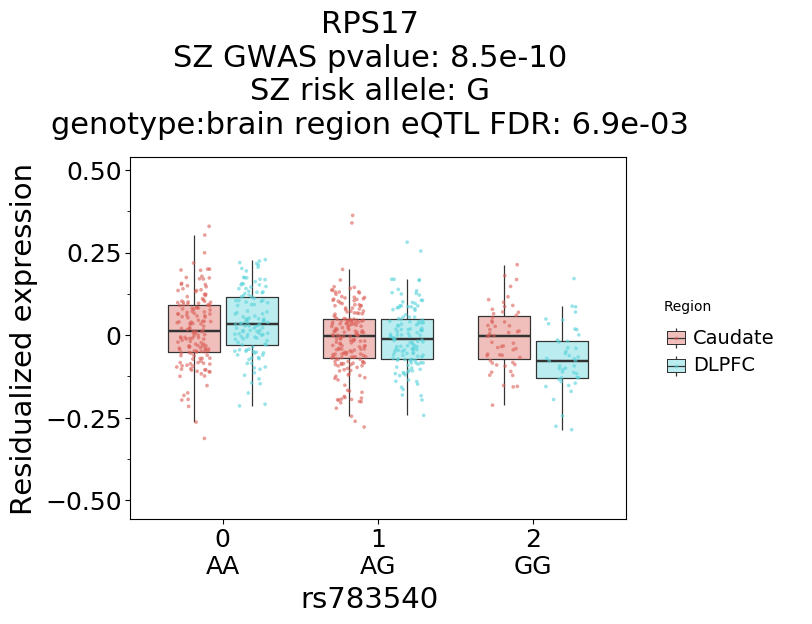

<ggplot: (8786303746892)>
top_7_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 7 rs1080500 ENSG00000163938.16


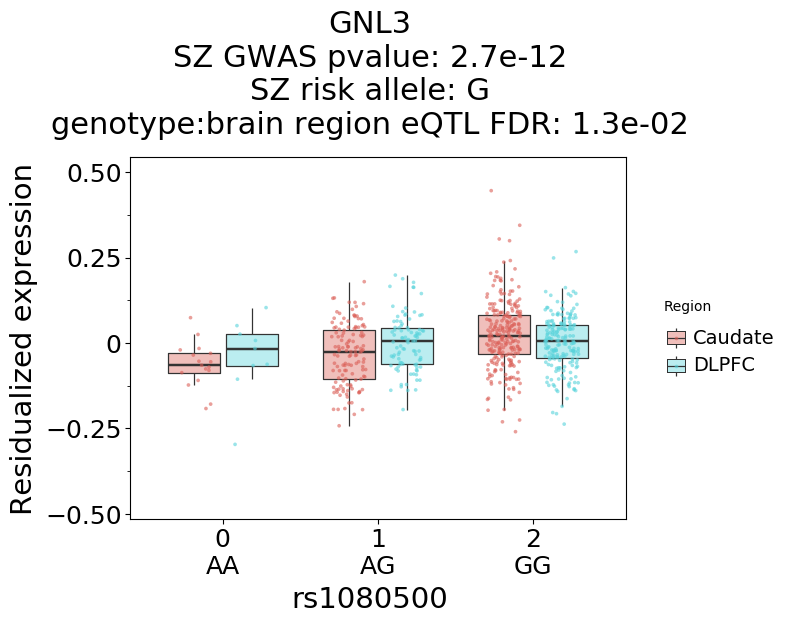

<ggplot: (8786303788273)>
top_8_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 8 12:2514112:A:G ENSG00000053702.14


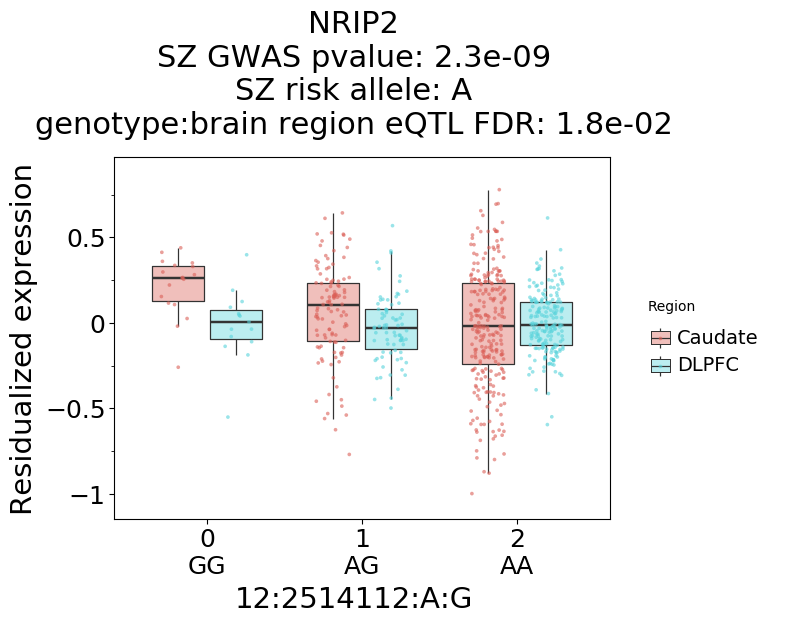

<ggplot: (8786291675630)>
top_9_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps 9 rs12293670:124612932:A:G ENSG00000154143.2


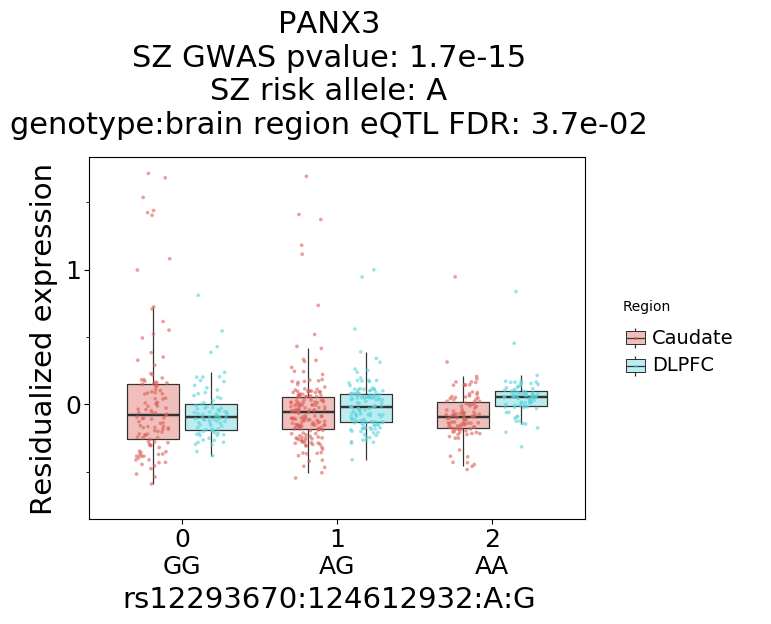

<ggplot: (8786303791821)>


In [18]:
top10 = top_gwas_eqtl_df.sort_values('p-value', ascending=True).groupby('gene').first().sort_values('p-value').head(10).reset_index()
for x  in top10.itertuples():
    filename = "top_%d_caudate_dlpfc_interaction_eqtl_in_gwas_significant_index_snps" % x.Index
    p = gwas_annotated_genotype_brain_region_interaction_eqtl_plot(x.SNP, x.gene)
    print(filename, x.Index, x.SNP, x.gene)
    print(p)
    save_plot(p, filename)

# eQTL for top GWAS index SNP

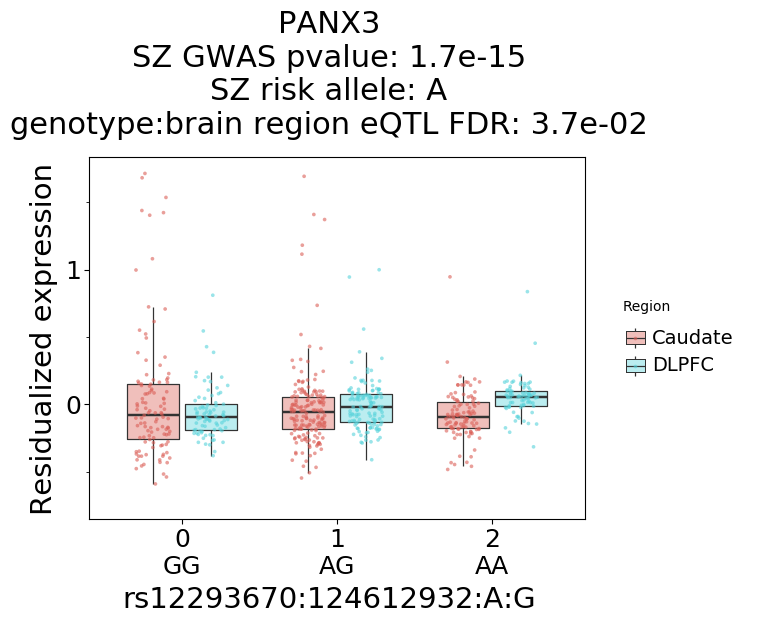

<ggplot: (8786304468294)>

In [19]:
a = top_gwas_eqtl_df.sort_values(['P', 'FDR'])
p = gwas_annotated_genotype_brain_region_interaction_eqtl_plot(a.iloc[0]['SNP'], a.iloc[0]['gene'])
save_plot(p, 'caudate_dlpfc_interaction_eqtl_for_top_index_snp')
p